<a href="https://colab.research.google.com/github/KaiaLee/KaiaLee/blob/main/fightTW.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 台灣班機延遲時間預測

載入套件

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

合併資料

In [4]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd

# 文件 ID 列表
file_ids = [
    '1EqM0JNdzGjhuOQL3SNCcRiAHdM2QoEcO',
    '1TIzwBTP7jVotetZ4IkCLIiBFARSVC80n',
    '1D0nUDKK94YF0KDAmPyj6Ll0nYtI_jbrb',
    '1uTOwQAcWdkiAcAMUrR_f0zl-iKHuW6iV',
    '1eAWWgt9PTZeqV7900_30cKTFvOag35pY',
    '1nhnpqICvAcZ3qLaN6qhQfZq0PBIX1IC0',
    '1r-yVDS-Lkpolg093cE3JWXuxFDzVJdjI',
    '1DCHXEkXMLLErUj_fAytwFajngYD2Yw88',
    '1aEqy4Av9M34c2BmVHejCN38UHA6tbHs7'
]

# 生成文件 URL
file_urls = [f'https://drive.google.com/uc?id={file_id}' for file_id in file_ids]

# 讀取並合併所有 CSV 文件
data_frames = [pd.read_csv(file_url) for file_url in file_urls]
data = pd.concat(data_frames, ignore_index=True)

# 檢查合併後的數據框
print(f"Total number of rows: {len(data)}")
print(data.head())


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<ipython-input-4-c76fa4dd0621>:23: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.
  data_frames = [pd.read_csv(file_url) for file_url in file_urls]
<ipython-input-4-c76fa4dd0621>:23: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.
  data_frames = [pd.read_csv(file_url) for file_url in file_urls]
<ipython-input-4-c76fa4dd0621>:23: DtypeWarning: Columns (1,12) have mixed types. Specify dtype option on import or set low_memory=False.
  data_frames = [pd.read_csv(file_url) for file_url in file_urls]
<ipython-input-4-c76fa4dd0621>:23: DtypeWarning: Columns (1,12) have mixed types. Specify dtype option on import or set low_memory=False.
  data_frames = [pd.read_csv(file_url) for file_url in file_urls]
<ipython-input-4-c76fa4dd0621>:23: DtypeWarning: Columns (1,12) have mixed types. Specify dtype option on import or set low_memory=False.
  data_frames = [pd.read_csv(file_url) for file_ur

Total number of rows: 4783072
                  FlightDate FlightNumber  AirRouteType AirlineID  \
0  2024-08-12 00:00:00+08:00         7016           NaN        DA   
1  2024-08-12 00:00:00+08:00         7010           NaN        DA   
2  2024-08-12 00:00:00+08:00         7012           NaN        DA   
3  2024-08-12 00:00:00+08:00         7016           NaN        DA   
4  2024-08-12 00:00:00+08:00         7012           NaN        DA   

  DepartureAirportID ArrivalAirportID      ScheduleDepartureTime  \
0                CMJ              MZG  2024-08-12 14:25:00+08:00   
1                CMJ              KHH  2024-08-12 11:40:00+08:00   
2                CMJ              KHH  2024-08-12 16:15:00+08:00   
3                CMJ              MZG  2024-08-12 14:25:00+08:00   
4                CMJ              KHH  2024-08-12 16:15:00+08:00   

  ActualDepartureTime EstimatedDepartureTime DepartureRemark  \
0                 NaN                    NaN              準時   
1                 

共 4783072 筆資料

---



airlineID 指的是航空公司\
flightnumber 指的是航班編號

### 資料清理

In [5]:
# 刪除不要的欄位
data = data.drop(columns=['AirRouteType', 'EstimatedDepartureTime', 'DepartureRemarkEn', 'Terminal', 'Gate', 'CodeShare', 'AcType', 'BaggageClaim', 'DepartureRemark', 'CheckCounter', 'UpdateTime'])

In [6]:
# 篩選出 'ActualDepartureTime' 為 NA 的行
is_na = data['ActualDepartureTime'].isna()
data = data.dropna(subset=['ActualDepartureTime'])

### 觀察資料
因不同航空AirlineID可能使用相同FlightNumber\
且聯合營運的情況下\
不同AirlineID、FlightNumber指的可能是同一班班機

---
以出發機場、抵達機場和實際出發時間來篩選出所有班次\
本次資料共 7408 班飛機班次


In [7]:
# 根據 'DepartureAirportID', 'ArrivalAirportID', 'ActualDepartureTime' 刪除重複行，保留最新一筆資料
data = data.sort_values(by=['ActualDepartureTime'], ascending=[False])
data = data.drop_duplicates(subset=['DepartureAirportID', 'ArrivalAirportID', 'ActualDepartureTime'], keep='last')

# 查看數據筆數（行數）
num_rows = len(data)
print(f"Number of rows: {num_rows}")

Number of rows: 7408


給這 7408 班飛機同航空的同一架飛機獨立識別名稱

In [8]:
# 合并 'FlightNumber' 和 'Airline' 列
data['AirlineFlight'] = data['AirlineID'] + '_' + data['FlightNumber'].astype(str)
data = data.drop(columns=['AirlineID', 'FlightNumber'])

## 新增'Delaymin'遲到分鐘數欄位

In [9]:
# 將字串轉換為時間序列格式
data['ScheduleDepartureTime'] = pd.to_datetime(data['ScheduleDepartureTime'])
data['ActualDepartureTime'] = pd.to_datetime(data['ActualDepartureTime'])
data['ScheduleDepartureTime'] .dt.tz

datetime.timezone(datetime.timedelta(seconds=28800))

In [10]:
# 新增延遲時間欄位
data['Delaymin'] = (data['ActualDepartureTime'] - data['ScheduleDepartureTime']).dt.total_seconds() / 60
print(data)

                        FlightDate DepartureAirportID ArrivalAirportID  \
4492667  2024-08-20 00:00:00+08:00                TPE              HKG   
4484003  2024-08-20 00:00:00+08:00                TPE              SEA   
4653447  2024-08-20 00:00:00+08:00                TPE              SZX   
4688355  2024-08-20 00:00:00+08:00                TPE              LAX   
4653342  2024-08-20 00:00:00+08:00                TPE              AMS   
...                            ...                ...              ...   
348952   2024-08-10 00:00:00+08:00                TPE              SIN   
349530   2024-08-10 00:00:00+08:00                TPE              SIN   
349531   2024-08-10 00:00:00+08:00                TPE              DWC   
349218   2024-08-10 00:00:00+08:00                TPE              HND   
348951   2024-08-10 00:00:00+08:00                TPE              SIN   

            ScheduleDepartureTime       ActualDepartureTime  IsCargo  \
4492667 2024-08-20 23:25:00+08:00 2024-

## 繪圖觀察 Delaymin 分布情形

Text(0.5, 1.0, 'Delaymin Distribution')

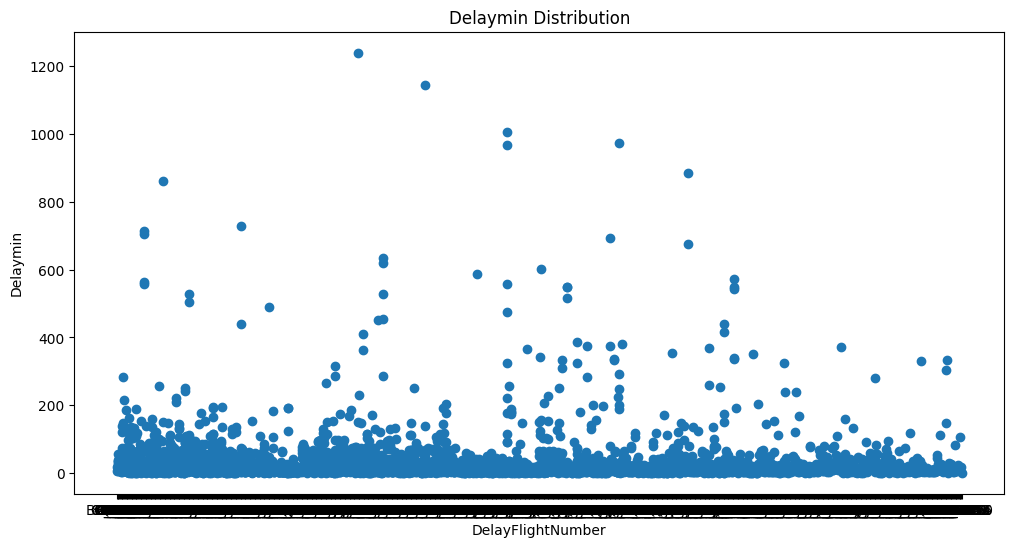

In [11]:
# 取出延遲的數據
delaydata = data[data['Delaymin'] > 0]

plt.figure(figsize=(12, 6))
plt.scatter(x=delaydata['AirlineFlight'], y=delaydata['Delaymin'])
plt.xlabel('DelayFlightNumber')
plt.ylabel('Delaymin')
plt.title('Delaymin Distribution')

Q1:6.0
Q2:12.0
Q3:28.0
lower_bound:-27.0
upper_bound:61.0


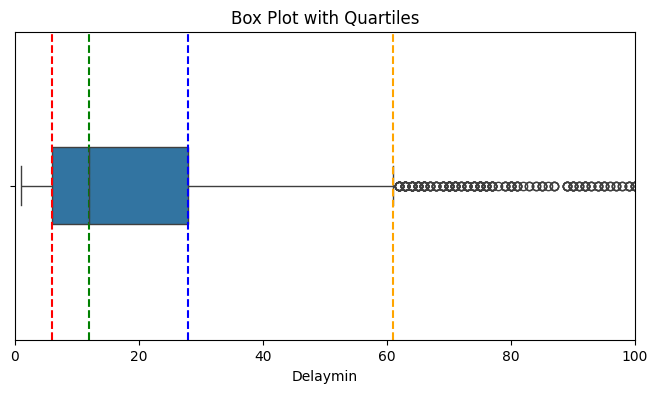

In [12]:
# 繪製盒型圖
plt.figure(figsize=(8, 4))
sns.boxplot(data=delaydata, x=delaydata['Delaymin'], orient='h', width=0.5)
plt.title('Box Plot with Quartiles')
plt.ylim(-1, 1)
plt.xlim(0, 100)

# 計算四分位数
Q1 = delaydata['Delaymin'].quantile(0.25)
Q2 = delaydata['Delaymin'].median()  # 也可以用 quantile(0.50)
Q3 = delaydata['Delaymin'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
print(f"Q1:{Q1}")
print(f"Q2:{Q2}")
print(f"Q3:{Q3}")
print(f"lower_bound:{lower_bound}")
print(f"upper_bound:{upper_bound}")

# 標示四分位数
plt.axvline(Q1, color='red', linestyle='--', label=f'Q1 (25th percentile): {Q1:.2f}')
plt.axvline(Q2, color='green', linestyle='--', label=f'Q2 (50th percentile): {Q2:.2f}')
plt.axvline(Q3, color='blue', linestyle='--', label=f'Q3 (75th percentile): {Q3:.2f}')

# 绘制超出范围的界限
plt.axvline(lower_bound, color='purple', linestyle='--', label=f'Lower Bound (Q1 - 1.5 * IQR): {lower_bound:.2f}')
plt.axvline(upper_bound, color='orange', linestyle='--', label=f'Upper Bound (Q3 + 1.5 * IQR): {upper_bound:.2f}')

plt.show()

# 從原始資料中取出一周資料

In [13]:
data['ScheduleDepartureTime'] = pd.to_datetime(data['ScheduleDepartureTime'], errors='coerce')
data['ActualDepartureTime'] = pd.to_datetime(data['ActualDepartureTime'], errors='coerce')

start_date = pd.to_datetime('2024-08-12 00:00:00').tz_localize('Asia/Taipei')
end_date = pd.to_datetime('2024-08-18 23:59:59').tz_localize('Asia/Taipei')

filtered_data = data[(data['ScheduleDepartureTime'] >= start_date) & (data['ScheduleDepartureTime'] <= end_date)]

print(filtered_data)

                        FlightDate DepartureAirportID ArrivalAirportID  \
3999659  2024-08-18 00:00:00+08:00                TPE              SFO   
3963300  2024-08-18 00:00:00+08:00                TPE              MNL   
4134259  2024-08-18 00:00:00+08:00                TPE              LAX   
4157189  2024-08-18 00:00:00+08:00                TPE              SFO   
4023885  2024-08-18 00:00:00+08:00                TPE              HKG   
...                            ...                ...              ...   
743820   2024-08-12 00:00:00+08:00                TPE              NGO   
390252   2024-08-12 00:00:00+08:00                TPE              SIN   
975829   2024-08-12 00:00:00+08:00                TPE              KUL   
358736   2024-08-12 00:00:00+08:00                TPE              SIN   
812159   2024-08-12 00:00:00+08:00                TPE              HND   

            ScheduleDepartureTime       ActualDepartureTime  IsCargo  \
3999659 2024-08-18 23:45:00+08:00 2024-

## 延遲時間預測的模型建置
模型：選用 Ridge線性回歸\
在Ridge中使用 L2 正則化防止模型過擬合\
並在模型中使用了多項式特徵\
將原始特徵擴展為多項式的形式\
形成X矩陣和y矩陣\
捕捉非線性關係

In [78]:
print(X)
print(X.shape)

[[0. 0. 0. ... 0. 1. 1.]
 [0. 0. 0. ... 0. 1. 1.]
 [0. 0. 0. ... 0. 1. 1.]
 ...
 [0. 0. 0. ... 0. 1. 1.]
 [0. 0. 0. ... 0. 1. 1.]
 [0. 0. 0. ... 0. 1. 1.]]
(5490, 118)


In [79]:
print(Y)
print(Y.shape)

[[100.]
 [227.]
 [ 78.]
 ...
 [  2.]
 [ -9.]
 [  1.]]
(5490, 1)


In [18]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(filtered_data['ArrivalAirportID'])

zipped = zip(integer_encoded, filtered_data['ArrivalAirportID'])
label_airports = list(set(zipped))
label_airports.sort(key=lambda x: x[0])

from sklearn.preprocessing import OneHotEncoder
# 初始化 OneHotEncoder，sparse_output=False 表示輸出稠密矩阵
onehot_encoder = OneHotEncoder(sparse_output=False)
# 擬合轉換數據
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
onehot_encoded = onehot_encoder.fit_transform(integer_encoded)

# 轉換時間特徵
filtered_data['ScheduleDepartureTime'] = pd.to_datetime(filtered_data['ScheduleDepartureTime'], errors='coerce')
filtered_data['ActualDepartureTime'] = pd.to_datetime(filtered_data['ActualDepartureTime'], errors='coerce')

# 將日期時間轉換為時間戳記
filtered_data['ScheduleDepartureTime'] = filtered_data['ScheduleDepartureTime'].astype(np.int64) // 10**9  # 轉換為秒
filtered_data['ActualDepartureTime'] = filtered_data['ActualDepartureTime'].astype(np.int64) // 10**9  # 轉換為秒

print(filtered_data.columns)

b = np.array(filtered_data[['ScheduleDepartureTime', 'ActualDepartureTime']])
X = np.hstack((onehot_encoded, b))
Y = np.array(filtered_data['Delaymin'])
Y = Y.reshape(len(Y), 1)

print(X.shape)
print(Y.shape)

from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25)

import numpy as np
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn import metrics

# 初始化最佳得分和参数
score_min = float('inf')
parameters = []

# 用迴圈找最佳的PolynomialFeatures多項式階數 和 alpha
for pol_order in range(1, 3):
    for alpha in range(0, 20, 2):
        # 創建多項式特徵
        poly = PolynomialFeatures(degree=pol_order)
        X_train_poly = poly.fit_transform(X_train)

        # 標準化特徵
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train_poly)

        # 創建 Ridge 回歸模型
        ridgereg = Ridge(alpha=alpha / 10)
        ridgereg.fit(X_train_scaled, Y_train)

        # 處理測試數據
        X_test_poly = poly.transform(X_test)
        X_test_scaled = scaler.transform(X_test_poly)
        result = ridgereg.predict(X_test_scaled)
        score = metrics.mean_squared_error(Y_test, result)

        # 更新最佳參數
        if score < score_min:
            score_min = score
            parameters = [alpha / 10, pol_order]

        print(f"n={pol_order} alpha={alpha / 10} , MSE = {score:.5f}")

<ipython-input-18-52337fb8fe85>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['ScheduleDepartureTime'] = pd.to_datetime(filtered_data['ScheduleDepartureTime'], errors='coerce')
<ipython-input-18-52337fb8fe85>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['ActualDepartureTime'] = pd.to_datetime(filtered_data['ActualDepartureTime'], errors='coerce')
<ipython-input-18-52337fb8fe85>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

Index(['FlightDate', 'DepartureAirportID', 'ArrivalAirportID',
       'ScheduleDepartureTime', 'ActualDepartureTime', 'IsCargo',
       'AirlineFlight', 'Delaymin'],
      dtype='object')
(5490, 118)
(5490, 1)
n=1 alpha=0.0 , MSE = 151335587896662424549075189760.00000
n=1 alpha=0.2 , MSE = 2325.68764
n=1 alpha=0.4 , MSE = 2325.67801
n=1 alpha=0.6 , MSE = 2325.66838
n=1 alpha=0.8 , MSE = 2325.65875
n=1 alpha=1.0 , MSE = 2325.64913
n=1 alpha=1.2 , MSE = 2325.63950
n=1 alpha=1.4 , MSE = 2325.62988
n=1 alpha=1.6 , MSE = 2325.62026
n=1 alpha=1.8 , MSE = 2325.61065


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:239: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


n=2 alpha=0.0 , MSE = 2580.44772
n=2 alpha=0.2 , MSE = 2325.69487
n=2 alpha=0.4 , MSE = 2325.69246
n=2 alpha=0.6 , MSE = 2325.69005
n=2 alpha=0.8 , MSE = 2325.68764
n=2 alpha=1.0 , MSE = 2325.68524
n=2 alpha=1.2 , MSE = 2325.68283
n=2 alpha=1.4 , MSE = 2325.68042
n=2 alpha=1.6 , MSE = 2325.67801
n=2 alpha=1.8 , MSE = 2325.67560


In [61]:
# 使用最佳參數重新訓練模型
poly = PolynomialFeatures(degree=parameters[1])
X_poly = poly.fit_transform(X)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_poly)

ridgereg = Ridge(alpha=parameters[0])
ridgereg.fit(X_scaled, Y)

# 進行預測
result = ridgereg.predict(X_scaled)
score = metrics.mean_squared_error(Y, result)
print(f'最佳參數 MSE　 = {score:.2f}')

# 將y做標籤
label_conversion = {s[1]: s[0] for s in label_airports}
filtered_data['Delaymin'] = filtered_data['Delaymin'].replace(label_conversion)

# 生成特徵矩陣
matrix = np.array([])  # 創建空模
for index, label in label_airports:
    temp = filtered_data['ArrivalAirportID'] == index
    temp = temp.apply(lambda x: 1.0 if x else 0.0)
    temp = np.array(temp)
    if matrix.size == 0:
        matrix = temp
    else:
        matrix = np.vstack((matrix, temp))
matrix = matrix.T

最佳參數 MSE　 = 3307.42


<ipython-input-61-d4628b6c3021>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['Delaymin'] = filtered_data['Delaymin'].replace(label_conversion)


評估最佳參數模型在整體數據上的表現

In [72]:
poly = PolynomialFeatures(degree=parameters[1])
X_poly = poly.fit_transform(X)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_poly)

ridgereg = Ridge(alpha=parameters[0])
ridgereg.fit(X_scaled, Y)

result = ridgereg.predict(X_scaled)
score = metrics.mean_squared_error(Y, result)
print(f'整體數據 MSE = {score:.2f}')

整體數據 MSE = 3307.42


In [51]:
print(matrix)
print(matrix.shape)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
(5490, 116)


將抵達機場做單熱編碼\
並轉換日期為時間戳記

In [75]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25)

print(X_train.shape)
print(Y_train.shape)

print(X_test.shape)
print(Y_test.shape)

(4117, 118)
(4117, 1)
(1373, 118)
(1373, 1)


# 訓練集 vs 測試集 MSE分數比較


In [87]:
# 對訓練集新數據作相同處理
poly = PolynomialFeatures(degree=parameters[1])
X_train_poly = poly.fit_transform(X_train)

# 標準化特徵
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_poly)

# 創建 Ridge 回歸模型
ridgereg = Ridge(alpha=parameters[0])
ridgereg.fit(X_train_scaled, Y_train)

ValueError: X has 118 features, but Ridge is expecting 119 features as input.

In [85]:
# 對測試集新數據作相同處理
poly = PolynomialFeatures(degree=parameters[1])
X_test_poly = poly.fit_transform(X_test)

# 標準化特徵
scaler = StandardScaler()
X_test_scaled = scaler.fit_transform(X_test_poly)

In [89]:
# 預測
Y_train_pred = ridgereg.predict(X_train_poly)
Y_test_pred = ridgereg.predict(X_test_poly)

# 計算訓練集 MSE
train_mse = metrics.mean_squared_error(Y_train, Y_train_pred)
print(f'訓練集 MSE = {train_mse:.2f}')
# 計算測試集 MSE
test_mse = metrics.mean_squared_error(Y_test, Y_test_pred)
print(f'測試集 MSE = {test_mse:.2f}')

訓練集 MSE = 3437.34
測試集 MSE = 3645.87


# 結論
模型可能存在過擬合，因此在訓練集上表現較好，在新的資料上表現較差。多項式回歸容易導致過擬合，因此除了以多項式得階數、正則化和alpha值調整之外，可再重新評估並選擇特徵、或使用其他模型如決策術或隨機森林，來找出最佳模型。

In [22]:
start_date = pd.to_datetime('2024-08-19 00:00:00').tz_localize('Asia/Taipei')
end_date = pd.to_datetime('2024-08-19 23:59:59').tz_localize('Asia/Taipei')

filtered_data_0819 = data[(data['ScheduleDepartureTime'] >= start_date) & (data['ScheduleDepartureTime'] <= end_date)]

print(filtered_data_0819)

                        FlightDate DepartureAirportID ArrivalAirportID  \
4625399  2024-08-19 00:00:00+08:00                TPE              MXP   
4565175  2024-08-19 00:00:00+08:00                TPE              LAX   
4521026  2024-08-19 00:00:00+08:00                TPE              LAX   
4655396  2024-08-19 00:00:00+08:00                TPE              SFO   
4441093  2024-08-19 00:00:00+08:00                TPE              LAX   
...                            ...                ...              ...   
4587062  2024-08-19 00:00:00+08:00                TPE              NGO   
4491987  2024-08-19 00:00:00+08:00                TPE              SIN   
4548506  2024-08-19 00:00:00+08:00                TPE              KUL   
4578356  2024-08-19 00:00:00+08:00                TPE              LAX   
4460544  2024-08-19 00:00:00+08:00                TPE              HND   

            ScheduleDepartureTime       ActualDepartureTime  IsCargo  \
4625399 2024-08-19 23:55:00+08:00 2024-

將 0819 共 762 班飛機航班的特徵丟進模型做預測

In [ ]:
print(type(label_airports))  # 應該顯示 <class 'list'>
print(label_airports)        # 檢查列表的內容

<class 'list'>
[(0, 'ANC'), (1, 'BKI'), (2, 'BKK'), (3, 'BNE'), (4, 'CAN'), (5, 'CDG'), (6, 'CEB'), (7, 'CGK'), (8, 'CGO'), (9, 'CJJ'), (10, 'CJU'), (11, 'CMJ'), (12, 'CNX'), (13, 'CRK'), (14, 'CTS'), (15, 'CYI'), (16, 'DAD'), (17, 'DMK'), (18, 'DPS'), (19, 'DXB'), (20, 'FOC'), (21, 'FRA'), (22, 'FUK'), (23, 'GMP'), (24, 'GNI'), (25, 'HAN'), (26, 'HGH'), (27, 'HIJ'), (28, 'HKD'), (29, 'HKG'), (30, 'HND'), (31, 'IAH'), (32, 'ICN'), (33, 'IST'), (34, 'JFK'), (35, 'KHH'), (36, 'KIJ'), (37, 'KIX'), (38, 'KMJ'), (39, 'KMQ'), (40, 'KNH'), (41, 'KUL'), (42, 'KYD'), (43, 'LAX'), (44, 'LHR'), (45, 'LZN'), (46, 'MEL'), (47, 'MFK'), (48, 'MFM'), (49, 'MNL'), (50, 'MUC'), (51, 'MXP'), (52, 'MZG'), (53, 'NGB'), (54, 'NGO'), (55, 'NKG'), (56, 'NRT'), (57, 'OKA'), (58, 'OKJ'), (59, 'ONT'), (60, 'ORD'), (61, 'PEK'), (62, 'PEN'), (63, 'PNH'), (64, 'PQC'), (65, 'PUS'), (66, 'PVG'), (67, 'RMQ'), (68, 'ROR'), (69, 'SDJ'), (70, 'SEA'), (71, 'SFO'), (72, 'SGN'), (73, 'SHA'), (74, 'SIN'), (75, 'SZX'), (76, '

In [23]:
# 原始的機場標籤列表
training_airports = set(filtered_data['ArrivalAirportID'].unique())

# 新數據中的機場標籤
new_airports = set(filtered_data_0819['ArrivalAirportID'].unique())

# 確認所有新數據中的機場標籤都屬於原始機場標籤列表
missing_airports = new_airports - training_airports

if len(missing_airports) == 0:
    print("所有新數據中的機場標籤都屬於原始機場標籤列表。")
else:
    print(f"以下機場標籤在原始標籤列表中不存在：{missing_airports}")

所有新数据中的机场标签都属于原始机场标签列表。


In [26]:
# 使用相同的 LabelEncoder 編碼新數據
new_integer_encoded = label_encoder.transform(filtered_data_0819['ArrivalAirportID'])

# 將新數據整數編碼做 one-hot encoding
new_integer_encoded = new_integer_encoded.reshape(len(new_integer_encoded), 1)
new_onehot_encoded = onehot_encoder.transform(new_integer_encoded)

print(new_onehot_encoded.shape)

(762, 116)


In [29]:
# 将独热编码结果转换为 DataFrame
onehot_df = pd.DataFrame(onehot_encoded, columns=[f'Airport_{i}' for i in range(onehot_encoded.shape[1])])
new_onehot_df = pd.DataFrame(new_onehot_encoded, columns=[f'Airport_{i}' for i in range(new_onehot_encoded.shape[1])])

# 确保列名顺序一致
onehot_df = onehot_df[onehot_df.columns.sort_values()]
new_onehot_df = new_onehot_df[new_onehot_df.columns.sort_values()]

# 输出
print(onehot_df.head())
print(new_onehot_df.head())

   Airport_0  Airport_1  Airport_10  Airport_100  Airport_101  Airport_102  \
0        0.0        0.0         0.0          0.0          0.0          0.0   
1        0.0        0.0         0.0          0.0          0.0          0.0   
2        0.0        0.0         0.0          0.0          0.0          0.0   
3        0.0        0.0         0.0          0.0          0.0          0.0   
4        0.0        0.0         0.0          0.0          0.0          0.0   

   Airport_103  Airport_104  Airport_105  Airport_106  ...  Airport_90  \
0          0.0          0.0          0.0          0.0  ...         0.0   
1          0.0          0.0          0.0          0.0  ...         0.0   
2          0.0          0.0          0.0          0.0  ...         0.0   
3          0.0          0.0          0.0          0.0  ...         0.0   
4          0.0          0.0          0.0          0.0  ...         0.0   

   Airport_91  Airport_92  Airport_93  Airport_94  Airport_95  Airport_96  \
0        

In [28]:
# 提取特徵
b = np.array(filtered_data_0819[['ScheduleDepartureTime', 'ActualDepartureTime']])

# 假設 matrix 是你之前訓練中用過的其他特徵
X = np.hstack((feature_matrix_template, b))

# 創建多項式特徵
X_poly = poly.transform(X)

# 標準化特徵
X_scaled = scaler.transform(X_poly)

# 使用訓練好的 Ridge 回歸模型進行預測
predicted_delays = ridgereg.predict(X_scaled)

# 這裡可以將預測結果存入 DataFrame 或進行其他操作
filtered_data_0819['PredictedDelay'] = predicted_delays

# 輸出或保存預測結果
print(filtered_data_0819[['ScheduleDepartureTime', 'ActualDepartureTime', 'PredictedDelay']])



ValueError: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 5490 and the array at index 1 has size 762

In [ ]:
# 將 Unix 時間戳轉換為日期時間格式
filtered_data_0819['ScheduleDepartureTime'] = pd.to_datetime(filtered_data_0819['ScheduleDepartureTime'], unit='s')
filtered_data_0819['ActualDepartureTime'] = pd.to_datetime(filtered_data_0819['ActualDepartureTime'], unit='s')

# 將 PredictedDelay 轉換為分鐘數
filtered_data_0819['PredictedDelayMinutes'] = filtered_data_0819['PredictedDelay'] / 60

# 顯示結果
print(filtered_data_0819[['ScheduleDepartureTime', 'ActualDepartureTime', 'PredictedDelayMinutes']])

        ScheduleDepartureTime ActualDepartureTime  PredictedDelayMinutes
4625399   2024-08-19 15:55:00 2024-08-19 16:40:00           -1572.105872
4565175   2024-08-19 15:50:00 2024-08-19 16:36:00           -1572.105872
4521026   2024-08-19 15:40:00 2024-08-19 16:34:00           -1572.105872
4655396   2024-08-19 15:30:00 2024-08-19 16:25:00           -1572.105872
4441093   2024-08-19 15:55:00 2024-08-19 16:21:00           -1572.105872
...                       ...                 ...                    ...
4587062   2024-08-18 17:55:00 2024-08-18 17:45:00           -1572.105872
4491987   2024-08-18 17:30:00 2024-08-18 17:22:00           -1572.105872
4548506   2024-08-18 17:25:00 2024-08-18 17:16:00           -1572.105872
4578356   2024-08-18 17:10:00 2024-08-18 17:02:00           -1572.105872
4460544   2024-08-18 16:10:00 2024-08-18 16:02:00           -1572.105872

[762 rows x 3 columns]


<ipython-input-141-200d1fbc5d65>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data_0819['ScheduleDepartureTime'] = pd.to_datetime(filtered_data_0819['ScheduleDepartureTime'], unit='s')
<ipython-input-141-200d1fbc5d65>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data_0819['ActualDepartureTime'] = pd.to_datetime(filtered_data_0819['ActualDepartureTime'], unit='s')
<ipython-input-141-200d1fbc5d65>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Dat

分析\
過擬合（Overfitting）:
訓練集 MSE 較低，而測試集 MSE 較高，這通常表示模型可能存在過擬合。即模型在訓練資料上表現很好，但在新的、未見過的資料上表現較差。\
\
模型複雜度:
多項式迴歸模型（或其他複雜模型）容易導致過度擬合，特別是在訓練集 MSE 遠低於測試集 MSE 時。需要檢查模型的複雜度（例如，多項式的階數、正規化參數等）。\
\
下一步建議\
\
調整模型複雜度:\
減少多項式的階數: 試著降低多項式特徵的階數，這樣可以減少模型的複雜度，從而減輕過擬合。\
\
調整正規化參數: 調整 Ridge 迴歸中的 alpha 值，增加正規化強度可以幫助減少過擬合。\
\
使用交叉驗證:使用交叉驗證（如 K-fold 交叉驗證）來評估模型的表現。這可以幫助確保模型在不同的資料子集上表現穩定，並且可以更全面地評估模型效能。\
\
特徵選擇:重新評估所使用的特徵，去除一些對目標變數預測影響不大的特徵，以提高模型的泛化能力。\
\
增加數據量:如果可能，增加訓練資料量可以幫助模型更好地學習資料的真實模式，從而減少過度擬合。\
\
模型評估:比較其他模型（如線性迴歸、決策樹、隨機森林等）在測試集上的 MSE，找出最適合你資料的模型

In [ ]:
# 打印索引映射
print("Airport to Index Mapping:")
for airport, index in airport_to_index.items():
    print(f"{airport}: {index}")

Airport to Index Mapping:
AKJ: 0
AKL: 1
AMS: 2
ANC: 3
AXT: 4
BKI: 5
BKK: 6
BNE: 7
BOM: 8
BWN: 9
CAN: 10
CDG: 11
CEB: 12
CGK: 13
CGO: 14
CJJ: 15
CJU: 16
CKG: 17
CMJ: 18
CNX: 19
CRK: 20
CTS: 21
CYI: 22
DAD: 23
DEL: 24
DMK: 25
DPS: 26
DSX: 27
DWC: 28
DXB: 29
FCO: 30
FKS: 31
FOC: 32
FRA: 33
FUK: 34
GMP: 35
GNI: 36
GYD: 37
HAN: 38
HGH: 39
HIJ: 40
HKD: 41
HKG: 42
HKT: 43
HNA: 44
HND: 45
HSG: 46
HUN: 47
IAH: 48
IBR: 49
ICN: 50
IST: 51
JFK: 52
KCZ: 53
KHH: 54
KIJ: 55
KIX: 56
KMJ: 57
KMQ: 58
KNH: 59
KOJ: 60
KUL: 61
KYD: 62
LAX: 63
LHR: 64
LZN: 65
MEL: 66
MFK: 67
MFM: 68
MNL: 69
MPH: 70
MUC: 71
MXP: 72
MYJ: 73
MZG: 74
NGB: 75
NGO: 76
NKG: 77
NRT: 78
OKA: 79
OKJ: 80
ONT: 81
ORD: 82
PEK: 83
PEN: 84
PNH: 85
PQC: 86
PRG: 87
PUS: 88
PVG: 89
RGN: 90
RMQ: 91
ROR: 92
SDJ: 93
SEA: 94
SFO: 95
SGN: 96
SHA: 97
SHJ: 98
SIN: 99
SYD: 100
SZX: 101
TAE: 102
TAK: 103
TAO: 104
TFU: 105
TNN: 106
TSA: 107
TTT: 108
VIE: 109
VII: 110
WOT: 111
WUH: 112
XMN: 113
YVR: 114
YYZ: 115
